# Detect Inspected Buildings

In damage assessment inspections, it's common that the structure needs to be fully inspected. One way to ensure that, is by having inspectors walk around the structure. In this example notebook, we'll how tracks can be used accomplish to identify structures that have been inspected. We'll use some sample data in Portland, ME to demonstrate this.

#### Import libraries and connect to the GIS

In [1]:
import arcgis
from datetime import datetime

gis = arcgis.gis.GIS("https://dev0007109.esri.com/portal", "tracker_analysis", verify_cert=False)

Enter password: ········


#### Fetch the building footprints

The building footprints are stored in a hosted feature layer. Let's query them and create a spatially enabled dataframe. We are using UTM Zone 19 as the spatial reference in order to have more accurate results.

In [2]:
sr ={'wkid': 32619, 'latestWkid': 32619}  # UTM Zone 19N
buildings_item = gis.content.get("c8aa37b7378641e79a0442b15efb359a")
buildings_df = buildings_item.layers[0].query(as_df=True, out_sr=sr)

#### Create a map and plot the buildings


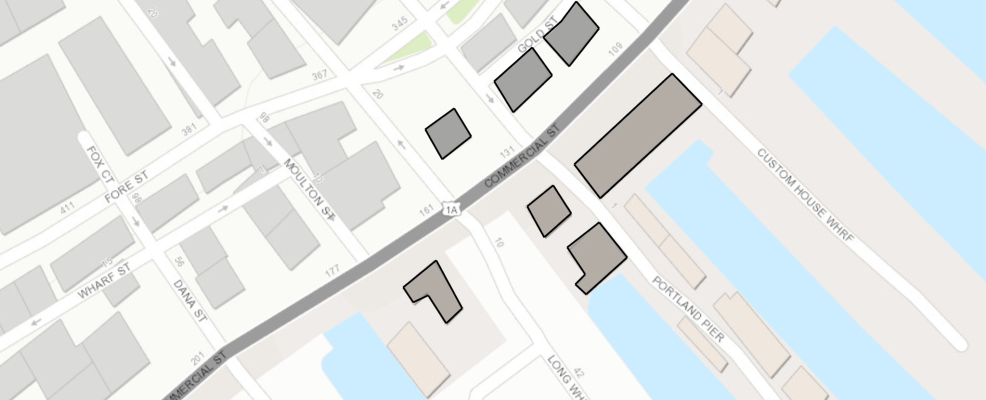

In [4]:
def create_webmap(*layers):
    webmap = gis.map("150 Commercial Street, Portland, ME", zoomlevel=18)
    for layer in layers:
        webmap.add_layer(layer)
    return webmap
create_webmap(buildings_df)

#### Overlay some track data
Let's load some track data to visualize the problem.


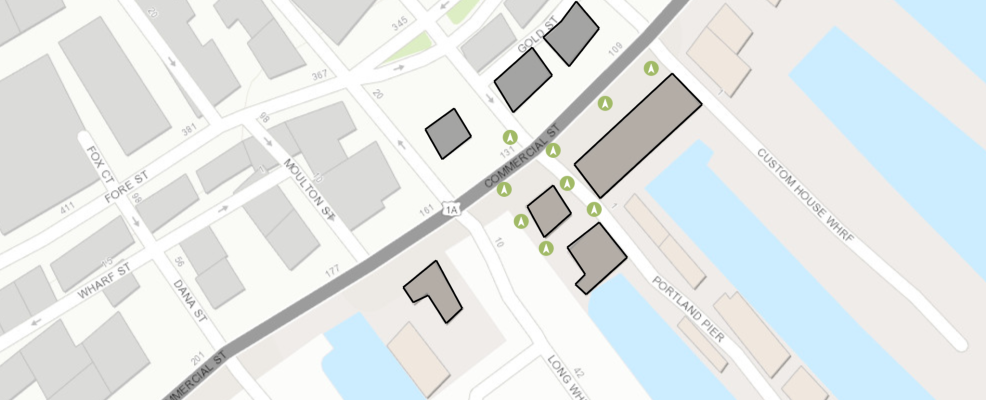

In [6]:
start_time = datetime(2020, 2, 1)
end_time = datetime(2020, 2, 2)
where_clause = f"location_timestamp >= timestamp '{start_time.strftime('%Y-%m-%d %H:%M:%S')}' AND location_timestamp < timestamp '{end_time.strftime('%Y-%m-%d %H:%M:%S')}'"
tracks_layer = arcgis.features.FeatureLayer(f'{gis.properties.helperServices["locationTracking"]["url"]}/0', gis)
tracks_layer.filter = where_clause
create_webmap(buildings_df, tracks_layer)

#### The algorithm

As you can see above, the tracks are around various buildings. The algorithm we are going to use is pretty simple:
1. For each of the building footprints
2. Buffer the building footprints by some distance (e.g 15 meters)
3. Determine which users tracks fall within that buffered area
4. For each user within the buffered area
   1. Fetch all of their tracks, sorted by `location_timestamp`
   2. Create a polygon based on those tracks points
   3. Determine if the created polygon fully contains the original building footprint. If so then mark the building as inspected.

First let's buffer all of the building footprints and add it to the map


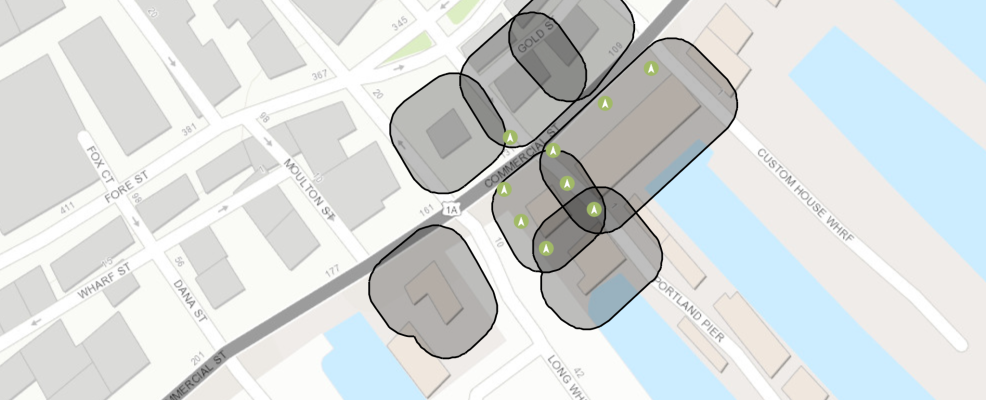

In [8]:
buildings_df["BUFFERED"] = buildings_df["SHAPE"].geom.buffer(15)
buildings_df.spatial.set_geometry("BUFFERED")
buildings_df.spatial.sr = sr
create_webmap(tracks_layer, buildings_df)

Now, let's iterate over the buildings and determine if it was inspected

In [9]:
# Iterate over the buildings
for index, row in buildings_df.iterrows():
    
    # Query the users with tracks that lie within the buffered zone for that building
    geom_filter = arcgis.geometry.filters.intersects(row['BUFFERED'], sr)
    users = tracks_layer.query(where=where_clause,
                               group_by_fields_for_statistics="created_user", 
                               out_statistics=[{"statisticType": "count", "onStatisticField": "objectid", "outStatisticFieldName": "count"}],
                               geometry_filter=geom_filter,
                               order_by="count").features
    
    # Iterate over the users
    for user in users:
        
        # Query the users tracks that fall within the buffered area
        tracks = tracks_layer.query(where=f"{where_clause} AND created_user='{user.attributes['created_user']}'",
                                   geometry_filter=geom_filter,
                                   order_by="location_timestamp",
                                   out_sr=sr).features
        
        # If more than 3 tracks were returned, create a polygon from the tracks
        if len(tracks) >= 3:
            geometry = {"rings": [[]],
                      "spatialReference": sr}
            for track in tracks:
                geometry["rings"][0].append([track.geometry["x"], track.geometry["y"]])
            polygon = arcgis.geometry.Polygon(geometry)
            
            # If the generated polygon contains the original building footprint, mark it as inspected
            if polygon.contains(row['SHAPE']):
                buildings_df.at[index, 'inspected'] = 1
                break

#### Visualize the results
Let's add another layer to the map with a custom renderer to show only the inspected buildings


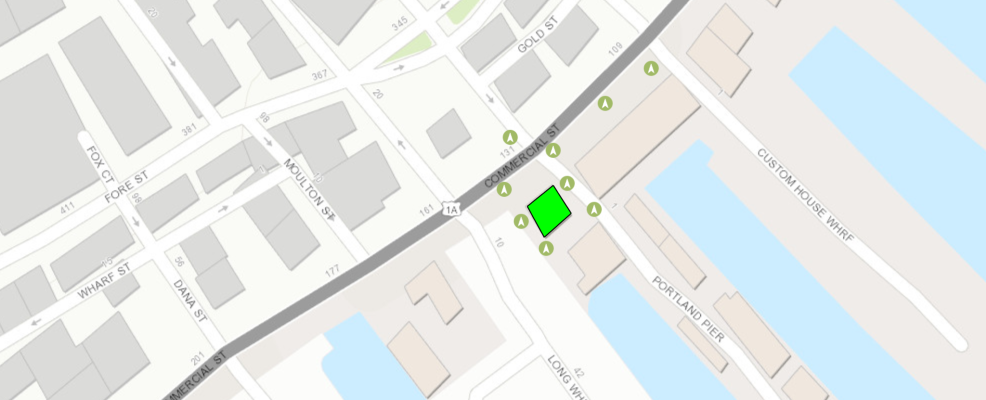

In [11]:
inspected_buildings = buildings_df.query("inspected == 1")
fc = arcgis.features.FeatureCollection.from_featureset(inspected_buildings.spatial.to_featureset())
drawing_info = {"renderer":{"type":"simple","symbol":{"color":[0,255,0,255],"outline":{"color":[0,0,0,255],"width":0.75,"type":"esriSLS","style":"esriSLSSolid"},"type":"esriSFS","style":"esriSFSSolid"}}}
fc.layer["layers"][0]["layerDefinition"]["drawingInfo"] = drawing_info
m = create_webmap(fc, tracks_layer)
m